In [0]:
import pandas as pd
import xgboost as xgb

In [0]:
#get this file from your computer  D:\2.personal\20190513_XGboost\1. Original data
df = pd.read_csv("2018_all_indicators.csv")

In [0]:
df = df[['dimension','indicator_name','iso3','country_name','2017']]

In [14]:
df.shape

(25636, 5)

In [0]:
df = df.dropna()

In [16]:
df.shape

(12728, 5)

In [17]:
df.iso3.unique().shape

(195,)

In [0]:
country_codes = list(df.iso3.unique())

In [0]:
def indicators_in_dimension(dimension):
    return list(df[df['dimension']==dimension]['indicator_name'].unique())

In [21]:
indicators_in_dimension("Health")

['Infants lacking immunization, DPT (% of one-year-olds)',
 'Infants lacking immunization, measles (% of one-year-olds)',
 'Life expectancy at birth (years)',
 'Life expectancy at birth, female (years)',
 'Life expectancy at birth, male (years)',
 'Life expectancy index']

In [0]:
def data_for_indicator(indicator):
    indicator_data = df[df['indicator_name']==indicator]
    zipped_values = zip(list(indicator_data['iso3']),list(indicator_data['2017']))
    return {k:{indicator : v} for k,v in zipped_values}

In [0]:
#This will be our label
life_expec = 'Life expectancy at birth (years)'
indic = data_for_indicator(life_expec)

In [0]:
for k, v in indic.items():
    print(k,v)

In [0]:
def add_indicator_to(dictionary, indicator):
    indicator_data = df[df['indicator_name']==indicator]
    zipped_values = zip(list(indicator_data['iso3']), list(indicator_data['2017']))
    for k, v in zipped_values:
        try:
            dictionary[k][indicator] = v
        except:
            print("failed with key: "+k+" on "+indicator)

In [26]:
vaccination = 'Infants lacking immunization, measles (% of one-year-olds)'
add_indicator_to(indic, vaccination)

failed with key: MCO on Infants lacking immunization, measles (% of one-year-olds)
failed with key: NRU on Infants lacking immunization, measles (% of one-year-olds)
failed with key: SMR on Infants lacking immunization, measles (% of one-year-olds)
failed with key: TUV on Infants lacking immunization, measles (% of one-year-olds)


In [27]:
indicators = [
    'Share of seats in parliament (% held by women)',
    'Infants lacking immunization, measles (% of one-year-olds)',
    'Youth unemployment rate (female to male ratio)',
    'Expected years of schooling (years)',
       'Expected years of schooling, female (years)',
       'Expected years of schooling, male (years)',
    'Unemployment, total (% of labour force)',
       'Unemployment, youth (% ages 15–24)',
       'Vulnerable employment (% of total employment)',
]
for indicator in indicators:
    add_indicator_to(indic, indicator)

failed with key: MCO on Share of seats in parliament (% held by women)
failed with key: NRU on Share of seats in parliament (% held by women)
failed with key: SMR on Share of seats in parliament (% held by women)
failed with key: TUV on Share of seats in parliament (% held by women)
failed with key: MCO on Infants lacking immunization, measles (% of one-year-olds)
failed with key: NRU on Infants lacking immunization, measles (% of one-year-olds)
failed with key: SMR on Infants lacking immunization, measles (% of one-year-olds)
failed with key: TUV on Infants lacking immunization, measles (% of one-year-olds)
failed with key: NRU on Expected years of schooling (years)
failed with key: SMR on Expected years of schooling (years)
failed with key: NRU on Expected years of schooling, female (years)
failed with key: SMR on Expected years of schooling, female (years)
failed with key: NRU on Expected years of schooling, male (years)
failed with key: SMR on Expected years of schooling, male (yea

In [0]:
final_df = pd.DataFrame(indic).transpose()

In [29]:
final_df.count()

Expected years of schooling (years)                           190
Expected years of schooling, female (years)                   179
Expected years of schooling, male (years)                     179
Infants lacking immunization, measles (% of one-year-olds)    189
Life expectancy at birth (years)                              191
Share of seats in parliament (% held by women)                189
Unemployment, total (% of labour force)                       180
Unemployment, youth (% ages 15–24)                            180
Vulnerable employment (% of total employment)                 180
Youth unemployment rate (female to male ratio)                180
dtype: int64

In [0]:
final_df =final_df.dropna()

In [31]:
final_df.count()

Expected years of schooling (years)                           170
Expected years of schooling, female (years)                   170
Expected years of schooling, male (years)                     170
Infants lacking immunization, measles (% of one-year-olds)    170
Life expectancy at birth (years)                              170
Share of seats in parliament (% held by women)                170
Unemployment, total (% of labour force)                       170
Unemployment, youth (% ages 15–24)                            170
Vulnerable employment (% of total employment)                 170
Youth unemployment rate (female to male ratio)                170
dtype: int64

/usr/local/lib/python3.6/dist-packages/matplotlib/tight_layout.py:181: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  warnings.warn('Tight layout not applied. '


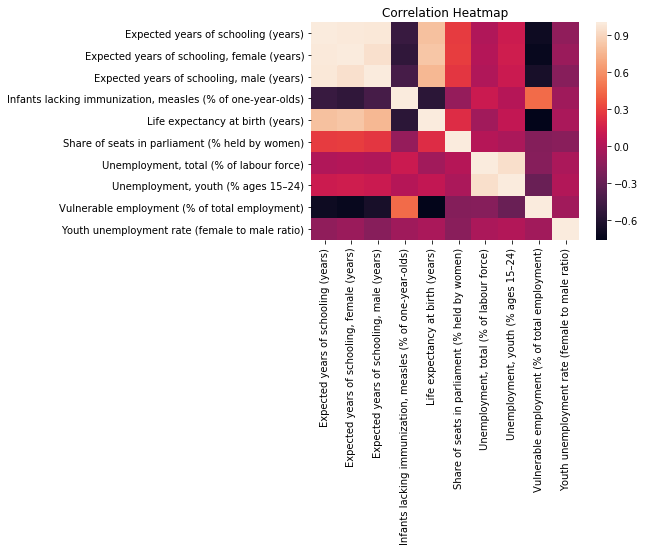

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
fig = sns.heatmap(final_df.corr())
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.savefig("correlation_heatmap", figsize=(96,72))

In [33]:
final_df[life_expec].describe()

count    170.000000
mean      72.163529
std        7.697211
min       52.200000
25%       66.800000
50%       73.800000
75%       77.400000
max       83.900000
Name: Life expectancy at birth (years), dtype: float64

In [0]:
#making sure the label is not one of the training features.
train_features = [feature for feature in list(final_df) if feature != life_expec]

#training data
train_df = final_df.iloc[:150][train_features]
train_label = final_df.iloc[:150][life_expec]

#test data
test_df = final_df.iloc[150:][train_features]
test_label = final_df.iloc[150:][life_expec]

In [35]:
import xgboost as xgb


dtrain = xgb.DMatrix(train_df, label=train_label)
dtest = xgb.DMatrix(test_df, label=test_label)
# specify parameters via map
param = {'max_depth':6,
         'eta':1,  #this is the default value anyway
         'colsample_bytree':1  #this is the default value anyway
        }

num_round = 15
initial_trees = xgb.train(param, dtrain, num_round)
# make prediction
first_preds = initial_trees.predict(dtest)

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [36]:
first_preds

array([68.66617 , 61.48115 , 74.0443  , 78.71511 , 78.14898 , 80.51852 ,
       72.17307 , 65.37586 , 75.38949 , 77.51605 , 82.26712 , 77.91969 ,
       71.2967  , 72.611015, 66.30306 , 75.065186, 77.31406 , 61.713524,
       70.75769 , 65.46725 ], dtype=float32)

In [37]:

import math 

def msesqrt(test_label, preds):
    squared_errors = [diff*diff for diff in (test_label - preds)]
    mse = sum(squared_errors)/len(preds)
    return math.sqrt(mse)

msesqrt(test_label, first_preds)

4.023551214123461

In [38]:
test_label - first_preds

TLS    0.533832
TGO   -0.981152
TON   -0.844296
TTO   -7.915111
TUN   -2.248979
TUR   -4.518517
TKM   -4.173073
UGA   -5.175862
UKR   -3.289488
ARE   -0.116052
GBR   -0.567120
USA    1.580307
URY    6.303300
UZB   -1.211015
VUT    5.996938
VEN   -0.365186
VNM   -0.814056
YEM    3.486476
ZMB   -8.457690
ZWE   -3.767247
Name: Life expectancy at birth (years), dtype: float64

In [0]:
param = {'max_depth':5,
         'eta':.1, 
         'colsample_bytree':.75 
        }
num_round = 40
new_tree = xgb.train(param, dtrain, num_round)
# make prediction
new_preds = new_tree.predict(dtest)

In [40]:
msesqrt(test_label, new_preds)

3.1542598764813596

In [41]:
test_label - new_preds

TLS   -0.854657
TGO   -3.954330
TON   -0.169690
TTO   -2.735004
TUN    0.132704
TUR   -0.790581
TKM   -0.779831
UGA   -3.915250
UKR   -2.329787
ARE    2.499434
GBR    1.294406
USA    2.790764
URY    3.438387
UZB    0.608466
VUT    7.423917
VEN   -0.666745
VNM    3.804672
YEM    0.537662
ZMB   -6.903094
ZWE   -2.687543
Name: Life expectancy at birth (years), dtype: float64

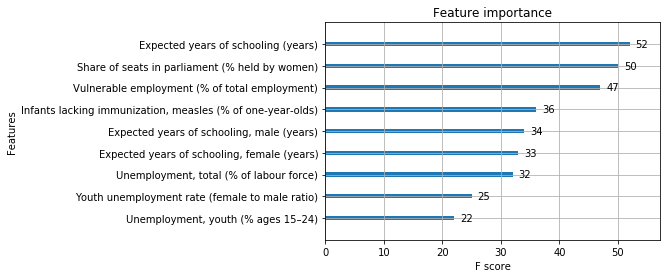

In [42]:
fig = xgb.plot_importance(new_tree)

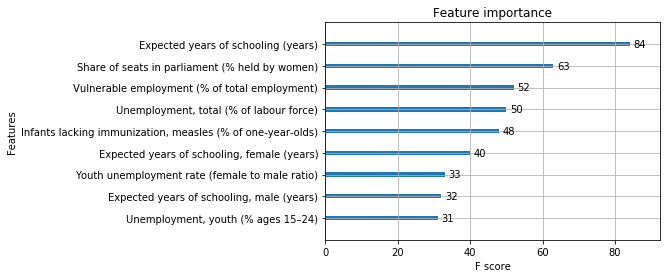

In [44]:
xgb.plot_importance(initial_trees)

In [0]:
agg_preds = (new_preds + first_preds)/2

In [46]:
agg_preds

array([69.36041 , 62.967743, 73.70699 , 76.12506 , 76.95814 , 78.65455 ,
       70.476456, 64.74556 , 74.90964 , 76.20831 , 81.33636 , 77.31447 ,
       72.72916 , 71.70128 , 65.58957 , 75.215965, 75.00469 , 63.18793 ,
       69.98039 , 64.9274  ], dtype=float32)

In [48]:
msesqrt(test_label, agg_preds)

3.3816703332355047